# Hagen Kahng EIG Partitioning Algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from numpy.linalg import eig as eigen
import random
plt.rcParams["figure.figsize"] = (15,12)

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
        self.node_part = {}
    
    def addNode(self, node, affiliation='p1'):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation
        self.node_part[node] = [node]
    
    def delNode(self, nodes):
        for i in nodes:
            self.nodes.remove(i)

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def consume_edge(self, edge):
        self.node_part[edge[0]] += self.node_part[edge[1]]
        self.nodes.remove(edge[1])
        weight_dicts = {}
        delete_indices  = []
        edges = self.adj_list

        for i in range(len(self.adj_list)):
            if(edges[i][0] == edge[1] and edges[i][1] != edge[0]):
                if(edges[i][1] in weight_dicts.keys()):
                    weight_dicts[edges[i][1]] += edges[i][2]
                else:
                    weight_dicts[edges[i][1]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] != edge[0]):
                if(edges[i][0] in weight_dicts.keys()):
                    weight_dicts[edges[i][0]] += edges[i][2]
                else:
                    weight_dicts[edges[i][0]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] == edge[0]):
                delete_indices.append(i)
            else:
                pass
        
        delete_indices.sort(reverse=True)
        for x in delete_indices:
            del self.adj_list[x]

        for p in weight_dicts.keys():
            self.addEdge(edge[0], p, weight_dicts[p])
        
        self.num_nodes = len(self.nodes)
    
    def get_heaviest_edge(self):
        sorted_edges = sorted(self.adj_list, key= lambda x: x[2], reverse=True)
        return sorted_edges[0] 
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost
    
    def IE(self, node):
        #(internal, external) cost of nodes
        internal, external = 0, 0
        d = self.node_affiliation
        p = d[node]
        for i in self.adj_list:
            if(i[0] == node):
                if(d[i[1]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            elif(i[1] == node):
                if(d[i[0]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            else:
                pass
        return (internal, external)


class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()
        self.colors = {}
    
    def reset(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p = list(set(self.graph.node_affiliation.values()))
        
        partitions = []
    
        for k in p:
            partitions.append([i for i in nodes if self.graph.node_affiliation[i] == k])
            if k not in self.colors.keys():
                self.colors[k] = '#%06X' % random.randint(0, 0xFFFFFF)
            
        
        node_colors = [self.colors[self.graph.node_affiliation[n]] for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = node_colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        
        legend_handles = []
        for i in p:
            legend_handles.append(mpatches.Patch(color=self.colors[i], label=i))
        plt.legend(handles=legend_handles)
        plt.show()

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random


def generate_benchmark(n=26, seed=20160):
    #n is number of nodes
    random.seed(seed)
    G = nx.erdos_renyi_graph(n, 0.5, seed=seed)

    for edge in G.edges():
        wt = random.randint(1,7)
        G[edge[0]][edge[1]]['weight'] = wt

    return G

def plot_benchmark(G, showedgewt = False): 
    pos = nx.spring_layout(G) 
    nx.draw_networkx(G, pos=pos, node_size=30, width=0.7)
    if showedgewt:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

def convert_to_our_graph(G, init_partition):
    hasher = lambda x : chr(list(G.nodes())[x] + 65) 
    graph = Graph()
    
    for i in range(len(G.nodes())):
        graph.addNode(hasher(i), init_partition[i])
    
    for edge in G.edges():
        graph.addEdge(hasher(edge[0]), hasher(edge[1]), G[edge[0]][edge[1]]['weight'])
    
    return graph

def init_partition_generator(m, n):
    return ['P1']*m + ['P2']*n  

In [3]:
gv = GraphVisualizer()

## The EIG algorithm visualized for a connected example benchmark graph

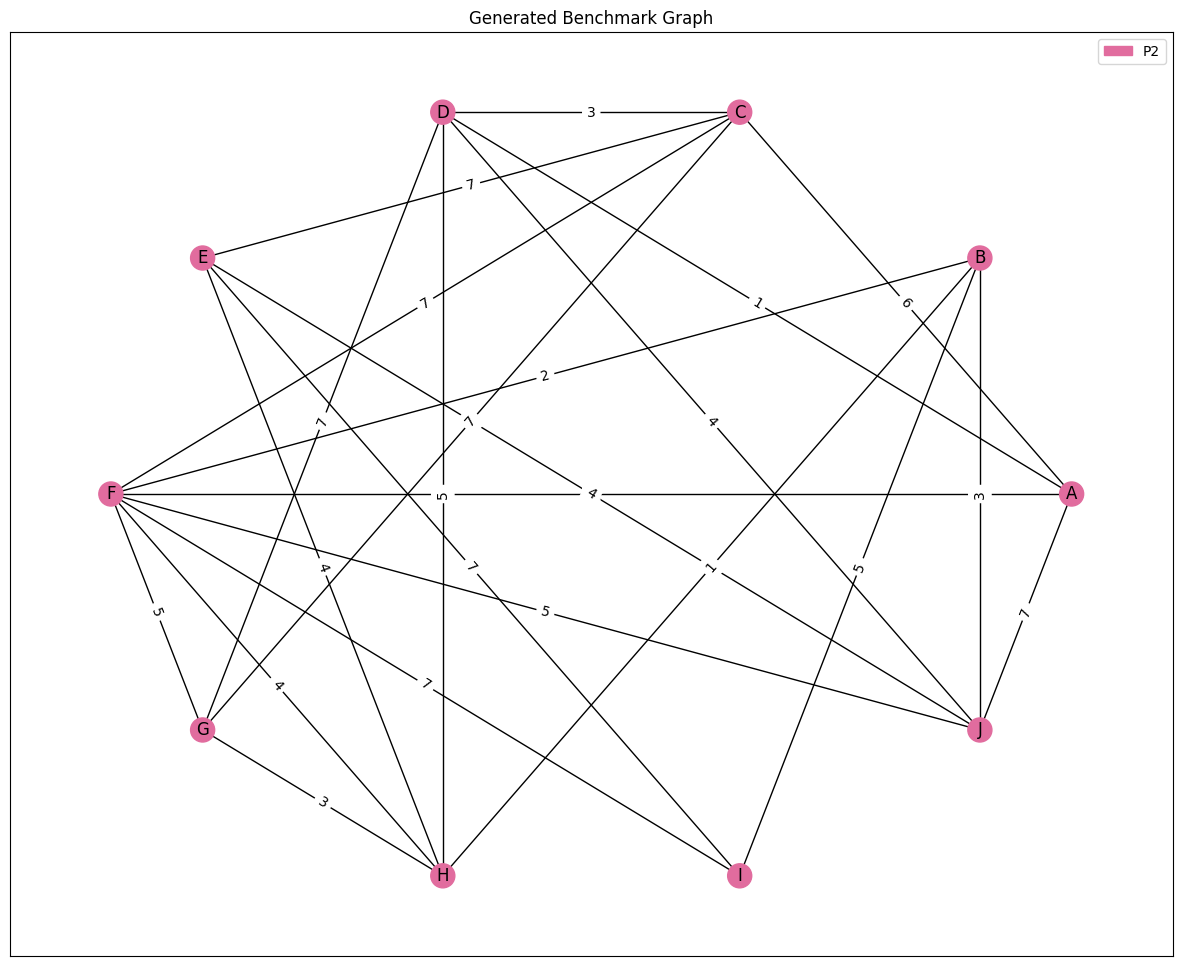

In [4]:
g = generate_benchmark(10, seed = 69)

graph = convert_to_our_graph(g, init_partition_generator(0,10))
gv.addEdges(graph)
gv.visualize("Generated Benchmark Graph")

In [5]:
def find_min(vector, used):
    min_value = 1
    min_i = 0
    for i, value in enumerate(vector):
        if (i not in used and value < min_value):
            min_value = value
            min_i = i
    return min_i

def eig(graph, visualized=True):
    global gv
    partitions = {"P1":[], "P2":[], "length(P1)":[], "length(P2)":[], "Cutsize" : [], "Ratio Cut" : []}
    nodes = graph.nodes
    lst = graph.adj_list
    Adj = np.zeros( (len(nodes), len(nodes)) )
    Deg = np.zeros( (len(nodes), len(nodes)) )
    
    I, E, D = {},{},{}
    
    for i, node in enumerate(nodes):
        I[node],E[node] = graph.IE(node)
        Deg[i][i] = I[node] + E[node]
    
    if visualized:
        print("The Degree Matrix is \n", Deg, "\n")
    
    for adj in lst:
        for i, node in enumerate(nodes):
            for j, node2 in enumerate(nodes):
                if ((node == adj[0]) and (node2 == adj[1])):
                    Adj[i][j] = adj[2]
                    Adj[j][i] = adj[2]
    if visualized:
        print("The Adjacency Matrix is \n", Adj, "\n")
    
    Lap = Deg - Adj
    
    if visualized:
        print("The Laplacian Matrix is \n", Lap, "\n")
    
    w,v = eigen(Lap)
    
    second_min = 1000;
    second_mini = 0;
    for i, value in enumerate(w):
        if (value != min(w) and value < second_min):
            second_min = value
            second_mini = i

    vector = v[second_mini]
    
    if visualized:
        print("Second smallest eigenvalue is", second_min)
        print("Corresponding eigenvector is \n", vector, "\n")
    
    used = []
    
    for i in range(len(nodes)-1):
        min_i = find_min(vector, used)
        used.append(min_i)
        min_node = nodes[min_i]
        graph.node_affiliation[min_node] = 'P1'
        rc = graph.get_cost()/((i+1)*(len(nodes)-i-1))
        cs = graph.get_cost()

        if visualized:
            gv.reset()
            gv.addEdges(graph)
            gv.visualize(f"For {i+1} : {len(nodes)-i-1} spectral EIG split partition")

        p1 = [k for k in graph.nodes if graph.node_affiliation[k] == 'P1']
        p2 = [k for k in graph.nodes if k not in p1]   

        partitions['P1'].append(p1)
        partitions['P2'].append(p2)
        partitions["Cutsize"].append(cs)
        partitions["Ratio Cut"].append(rc)
        partitions["length(P1)"].append(len(p1))
        partitions["length(P2)"].append(len(p2))
    
    return partitions

The Degree Matrix is 
 [[15.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 30.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 20.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 22.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 31.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 22.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 17.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 19.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 23.]] 

The Adjacency Matrix is 
 [[0. 0. 6. 1. 0. 1. 0. 0. 0. 7.]
 [0. 0. 0. 0. 0. 2. 0. 1. 5. 3.]
 [6. 0. 0. 3. 7. 7. 7. 0. 0. 0.]
 [1. 0. 3. 0. 0. 0. 7. 5. 0. 4.]
 [0. 0. 7. 0. 0. 0. 0. 4. 7. 4.]
 [1. 2. 7. 0. 0. 0. 5. 4. 7. 5.]
 [0. 0. 7. 7. 0. 5. 0. 3. 0. 0.]
 [0. 1. 0. 5. 4. 4. 3. 0. 0. 0.]
 [0. 5. 0. 0. 7. 7. 0. 0. 0. 0.]
 [7. 3. 0. 4. 4. 5. 0. 0. 0. 0.]] 

The Laplacian Matrix is 
 [[15.  0. -6. -1.  0. -1.  0.  0.  0. -7.]
 [ 0. 11.  0.  0.  0. -2.  0. -1. -5. -3.]
 [-6.  0. 30. -3. -7. -7. -7.  0.  0.  0.]
 [-1.  0. -3. 20.  0.  0. -7. 

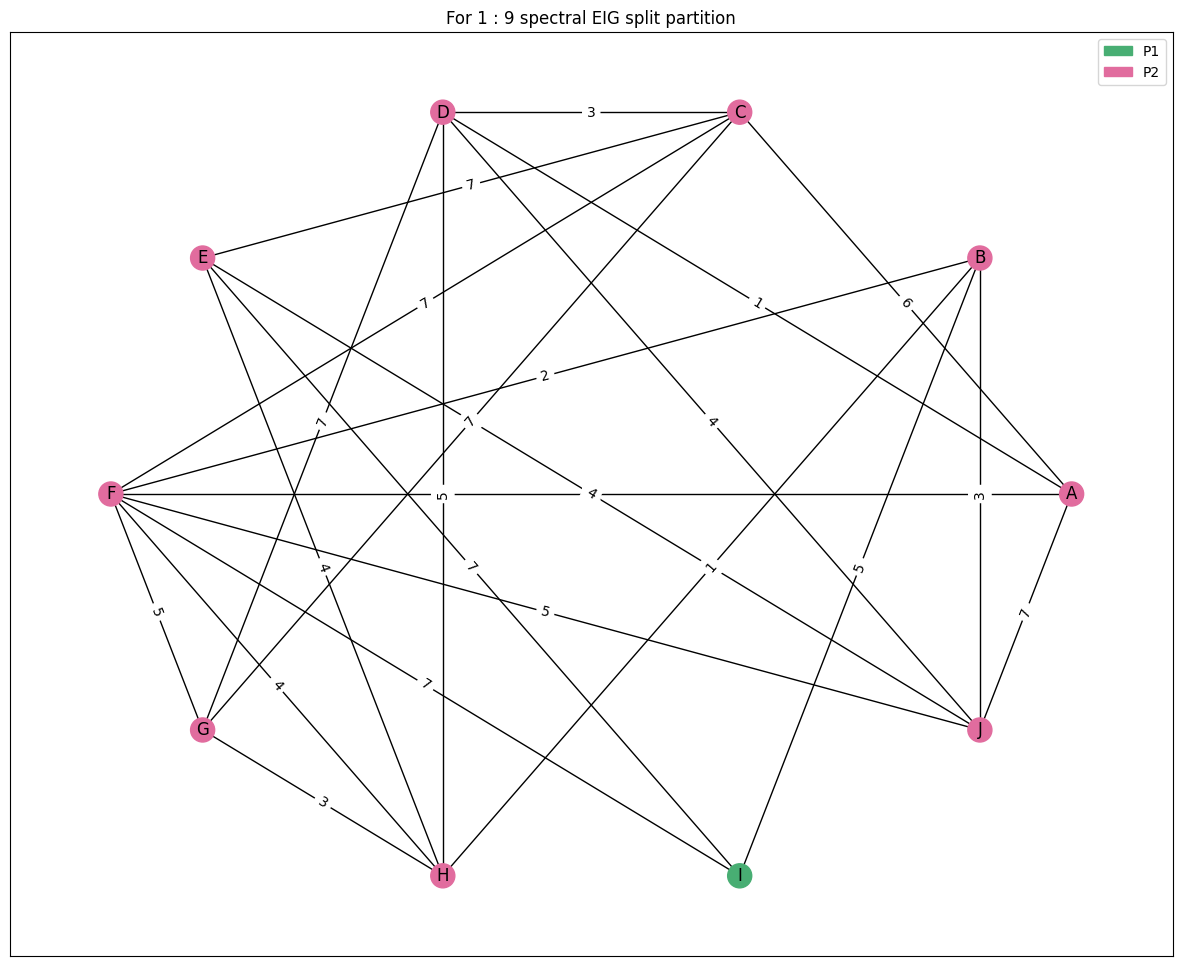

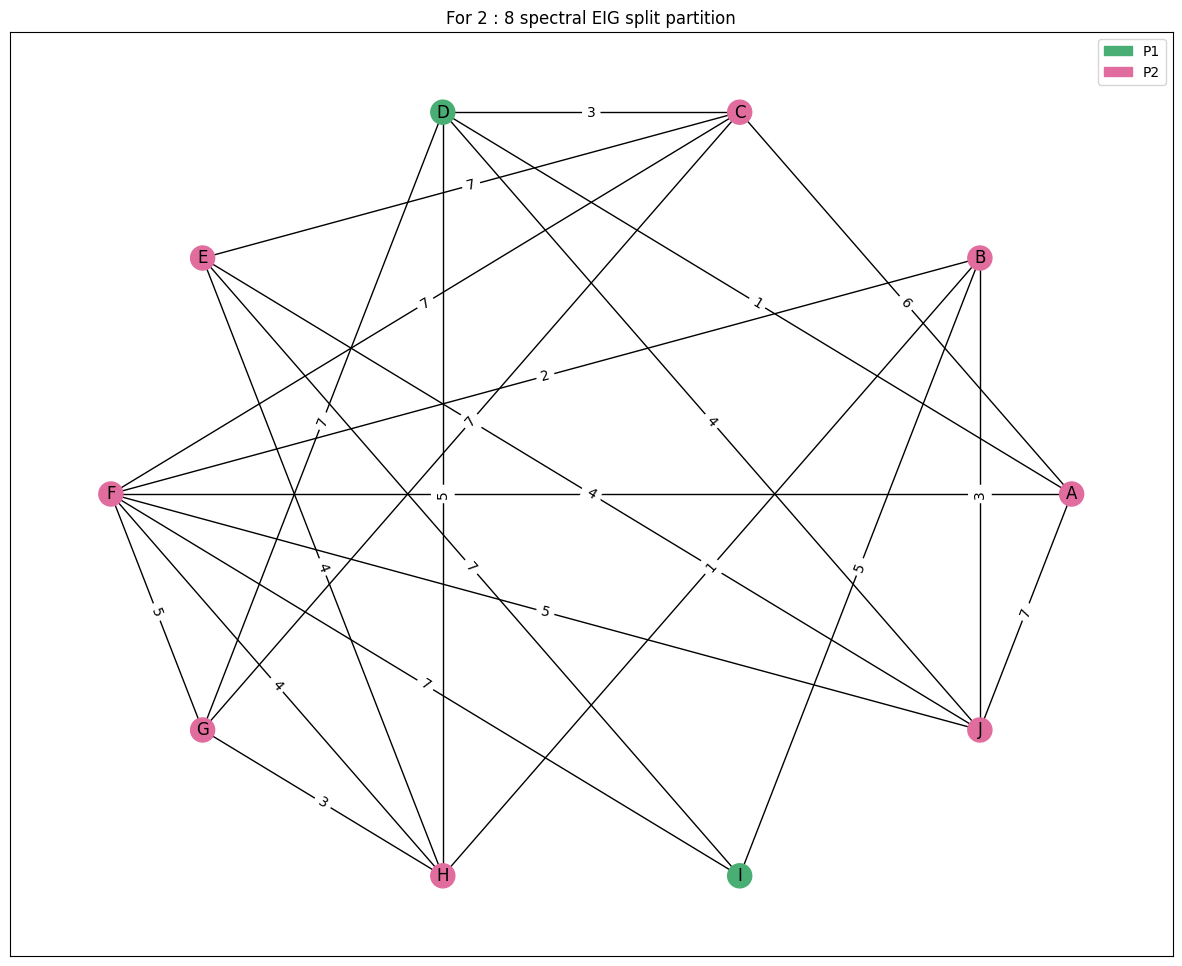

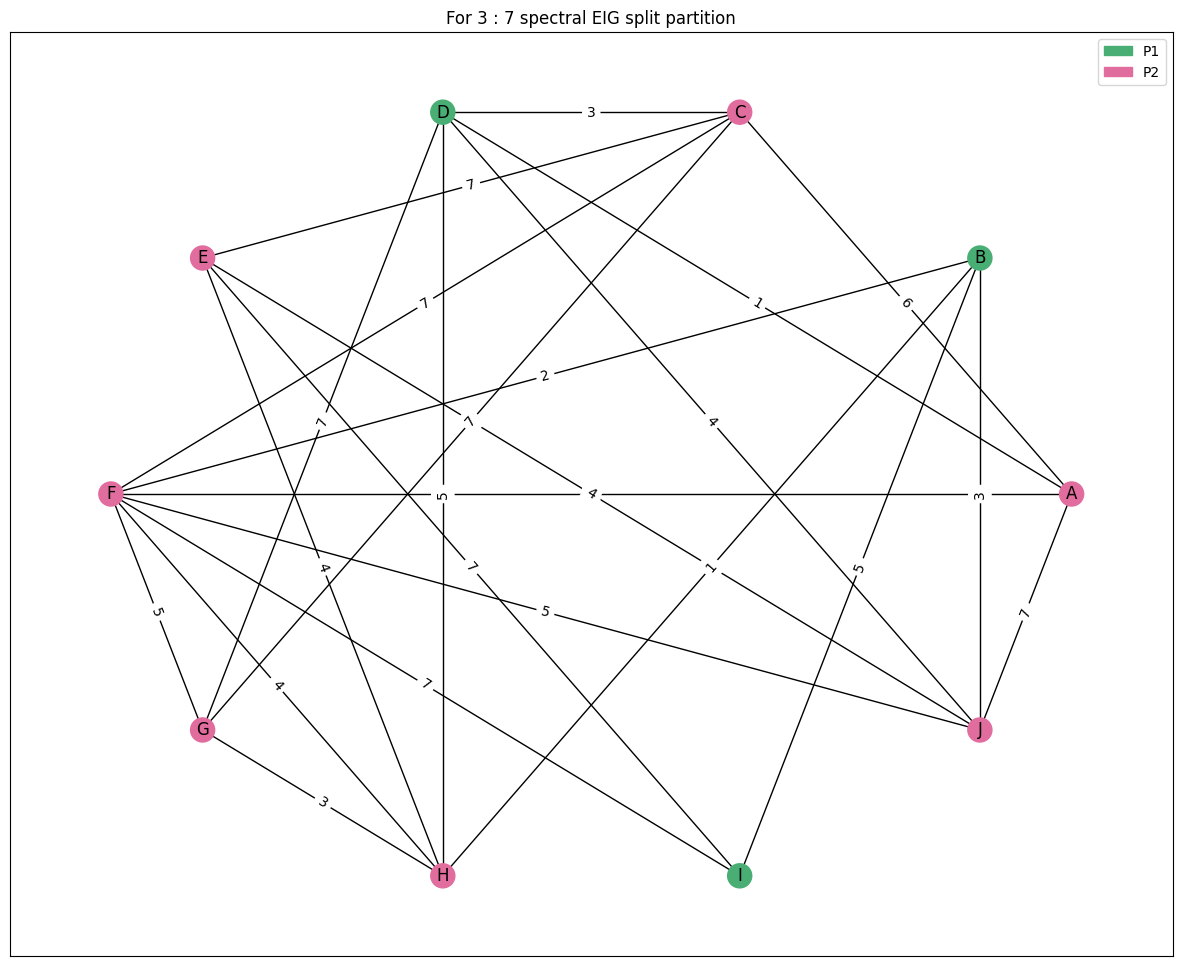

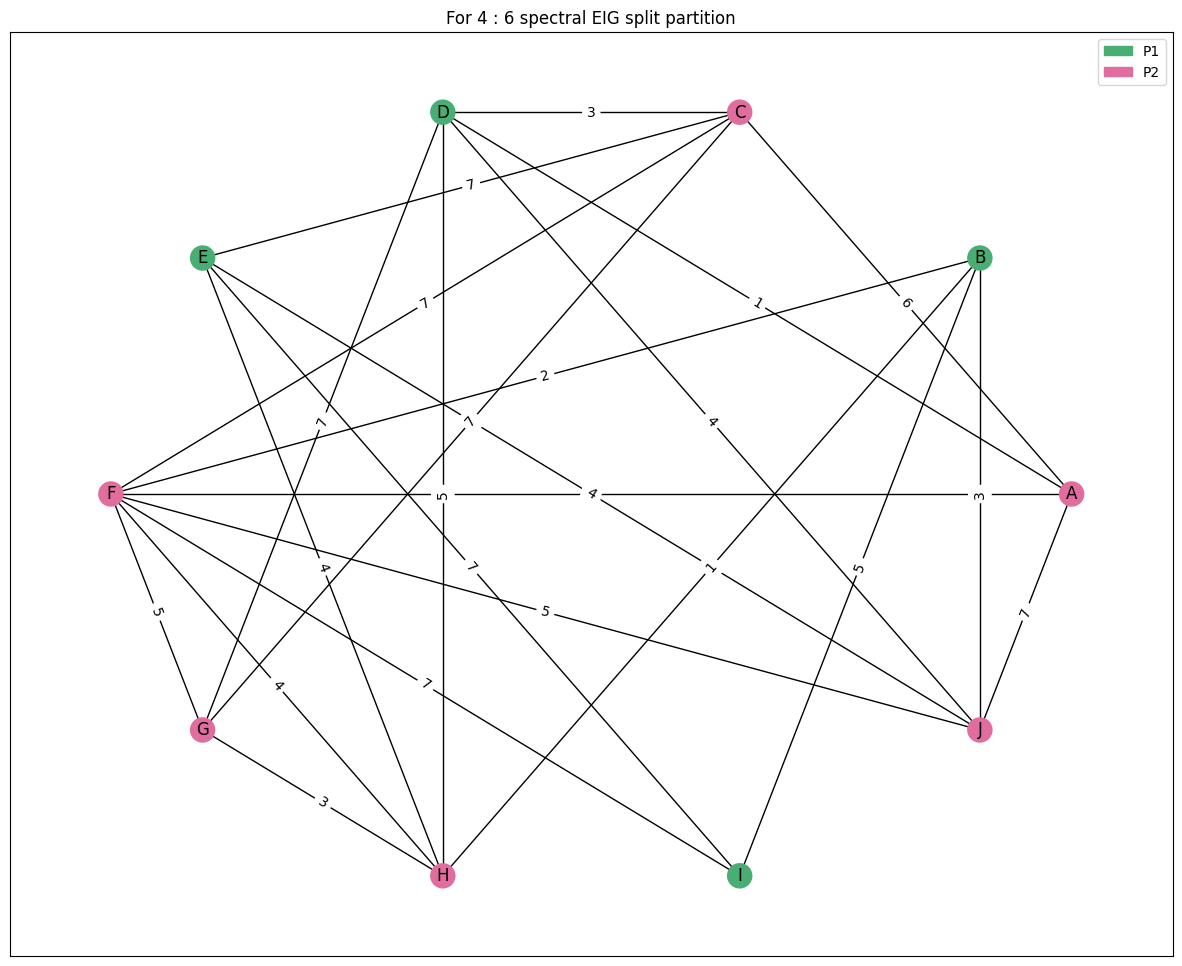

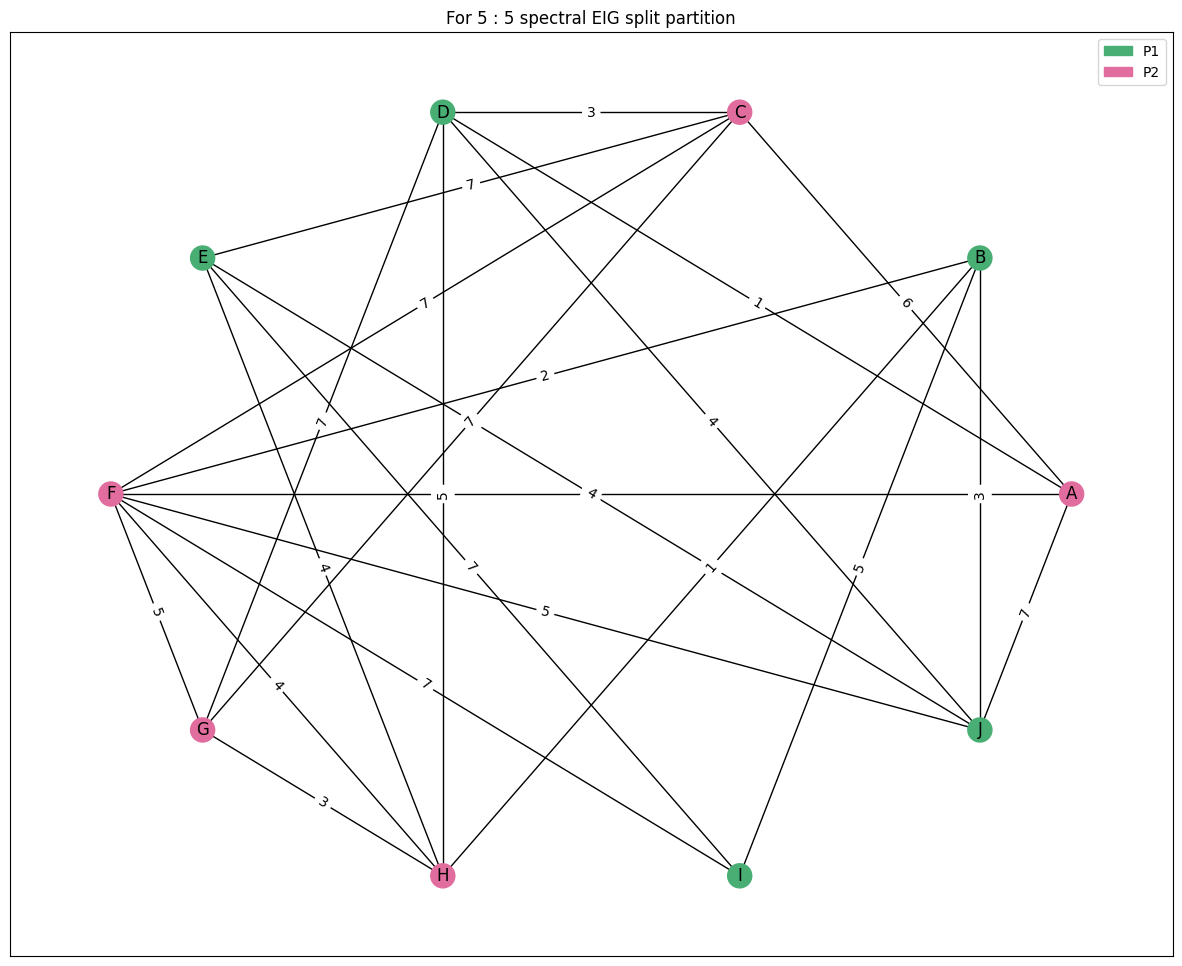

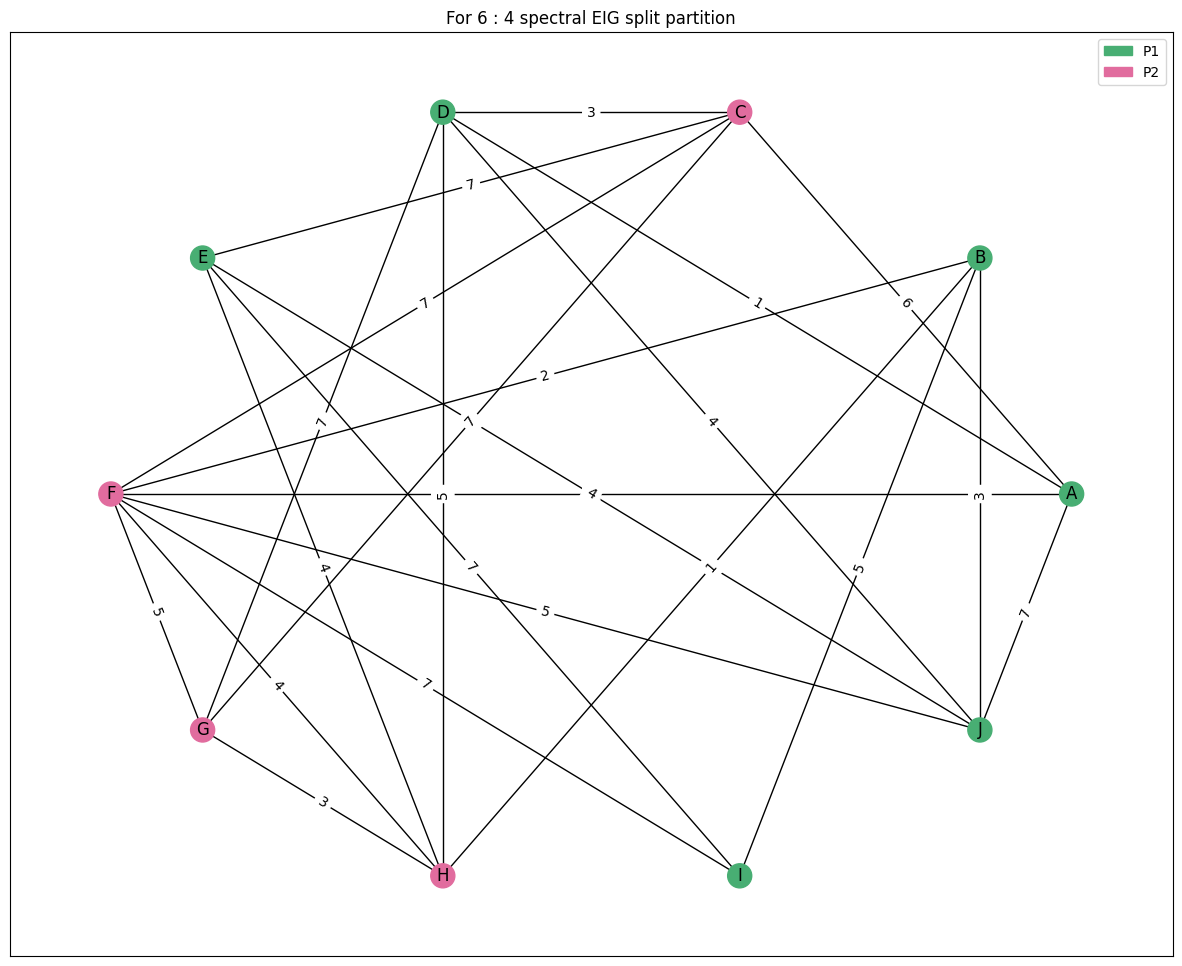

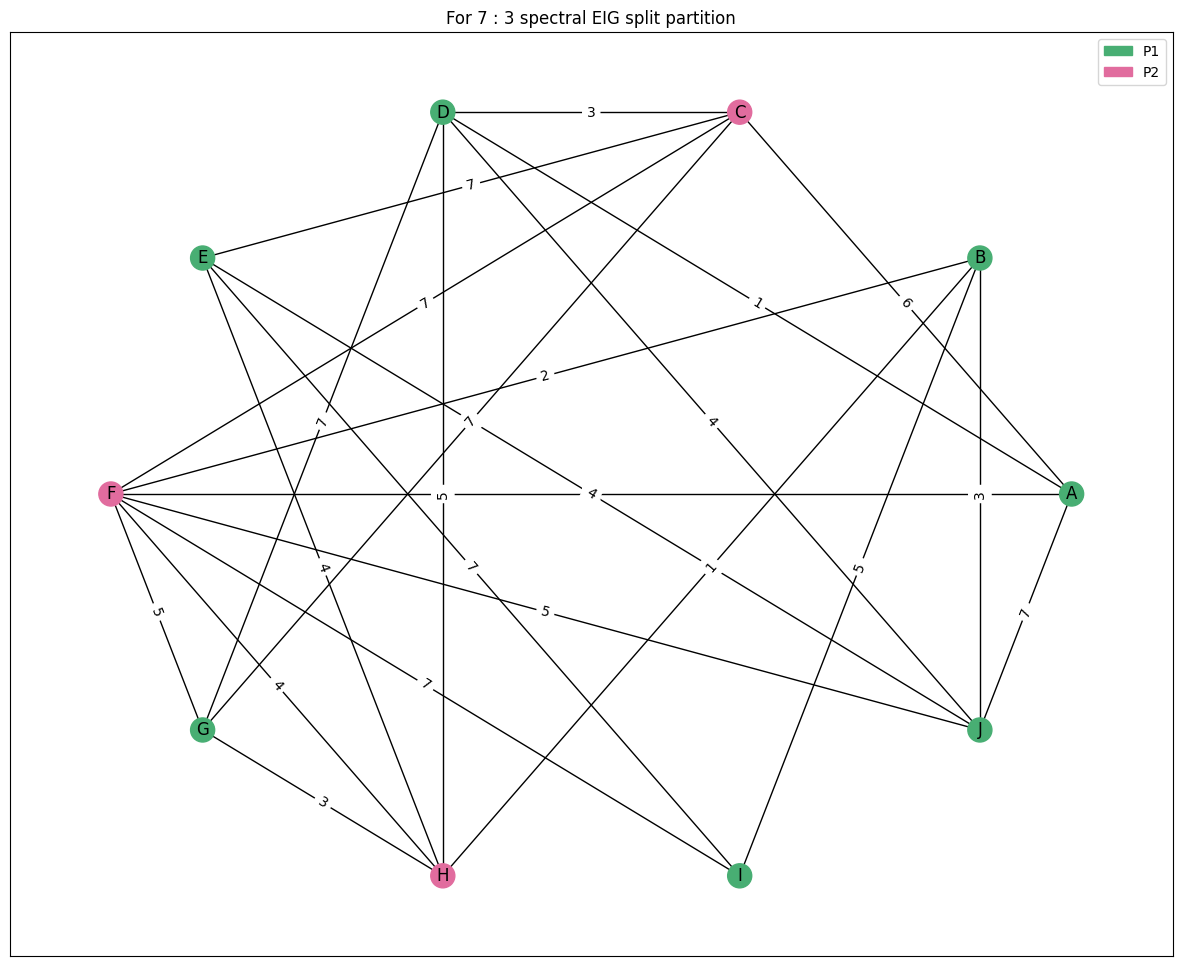

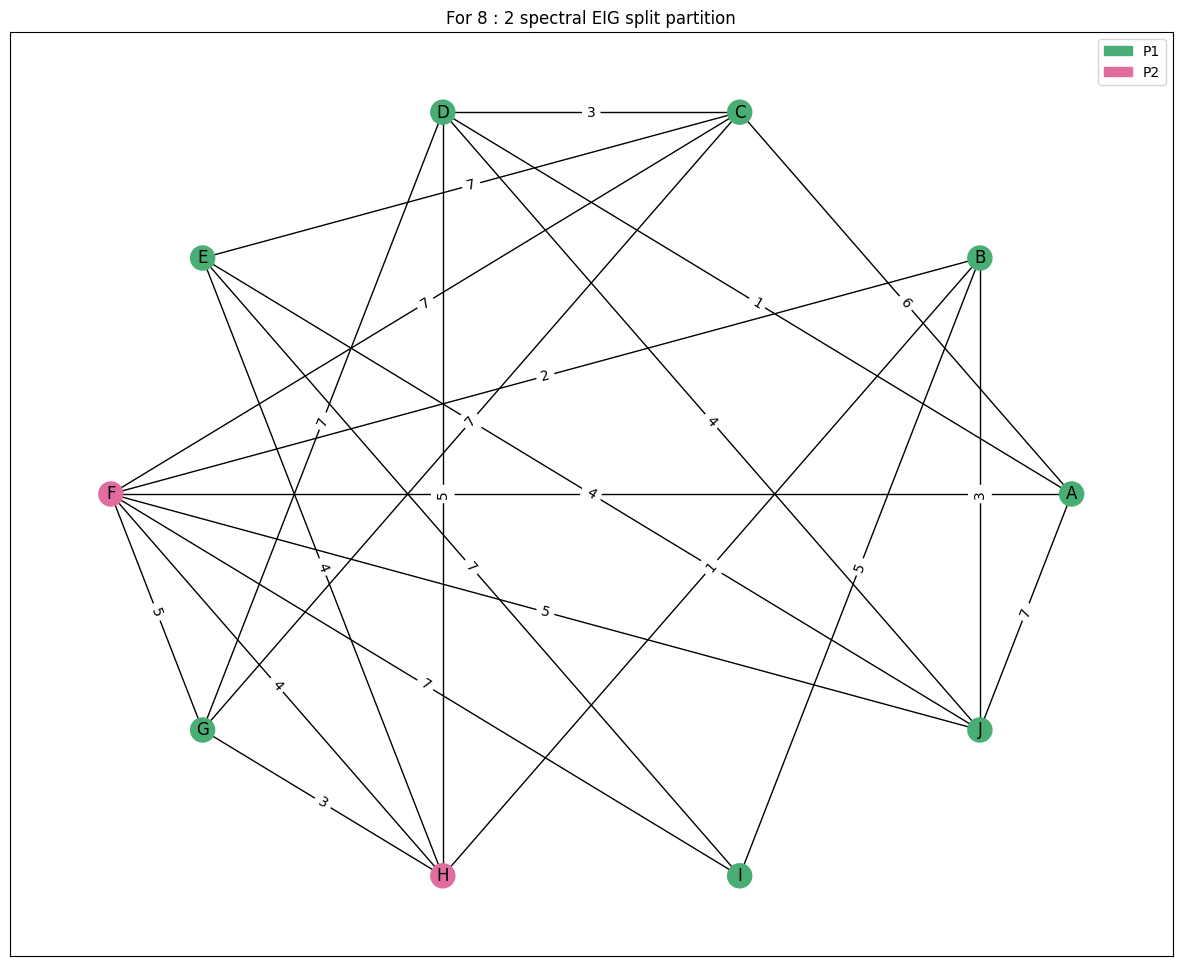

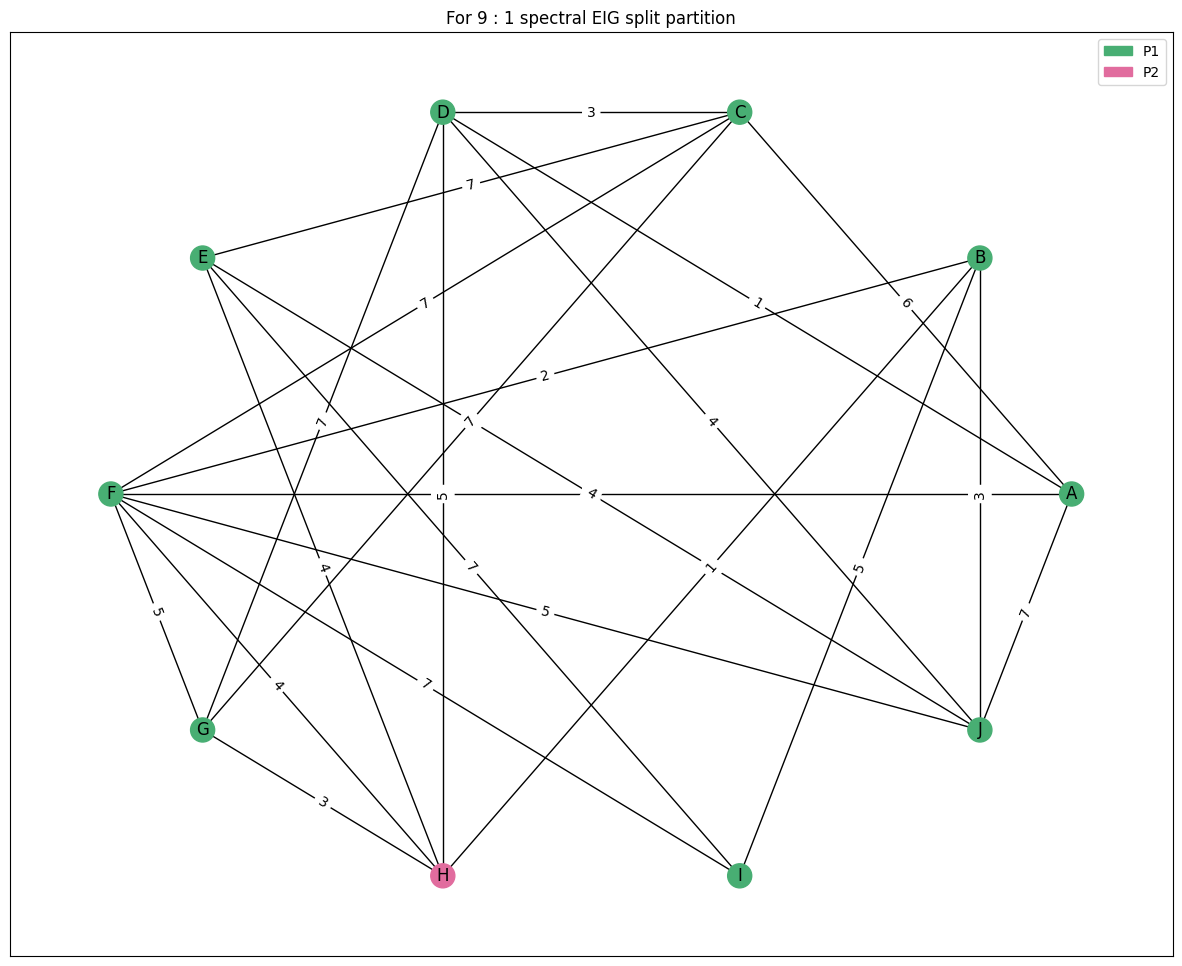

In [6]:
import pandas as pd
result = pd.DataFrame(eig(graph))

In [7]:
display(result)

,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[I],"[A, B, C, D, E, F, G, H, J]",1,9,19,2.111111
1,"[D, I]","[A, B, C, E, F, G, H, J]",2,8,39,2.437500
2,"[B, D, I]","[A, C, E, F, G, H, J]",3,7,40,1.904762
3,"[B, D, E, I]","[A, C, F, G, H, J]",4,6,48,2.000000
4,"[B, D, E, I, J]","[A, C, F, G, H]",5,5,49,1.960000
5,"[A, B, D, E, I, J]","[C, F, G, H]",6,4,48,2.000000
6,"[A, B, D, E, G, I, J]","[C, F, H]",7,3,56,2.666667
7,"[A, B, C, D, E, G, I, J]","[F, H]",8,2,40,2.500000
8,"[A, B, C, D, E, F, G, I, J]",[H],9,1,17,1.888889


# Analysis of this method of Partitioning

To analyse this algorithm, we perform the following, we shall take 15 different networks of increasing sizes, which we shall use to compare the various algorithms, and tabulate for each example

In [8]:
results = {}
for i in range(10, 26):
    g = generate_benchmark(i, seed = 440+i)
    graph = convert_to_our_graph(g, init_partition_generator(0,i))
    results[i] = pd.DataFrame(eig(graph, visualized=False))

Here are the results

In [9]:
ratio_cuts = []
cutsizes = []

for i in results.keys():
    print(f"For the benchmark graph with {i} nodes, here is the tabulated results")
    ratio_cuts += list(results[i]['Ratio Cut'])
    cutsizes += list(results[i]['Cutsize'])
    display(results[i])

For the benchmark graph with 10 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[J],"[A, B, C, D, E, F, G, H, I]",1,9,7,0.777778
1,"[B, J]","[A, C, D, E, F, G, H, I]",2,8,30,1.875000
2,"[B, D, J]","[A, C, E, F, G, H, I]",3,7,42,2.000000
3,"[B, D, G, J]","[A, C, E, F, H, I]",4,6,50,2.083333
4,"[B, D, F, G, J]","[A, C, E, H, I]",5,5,40,1.600000
5,"[B, C, D, F, G, J]","[A, E, H, I]",6,4,28,1.166667
6,"[B, C, D, E, F, G, J]","[A, H, I]",7,3,33,1.571429
7,"[B, C, D, E, F, G, I, J]","[A, H]",8,2,12,0.750000
8,"[A, B, C, D, E, F, G, I, J]",[H],9,1,7,0.777778


For the benchmark graph with 11 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[C],"[A, B, D, E, F, G, H, I, J, K]",1,10,9,0.900000
1,"[A, C]","[B, D, E, F, G, H, I, J, K]",2,9,20,1.111111
2,"[A, C, G]","[B, D, E, F, H, I, J, K]",3,8,38,1.583333
3,"[A, C, G, I]","[B, D, E, F, H, J, K]",4,7,33,1.178571
4,"[A, C, G, H, I]","[B, D, E, F, J, K]",5,6,39,1.300000
5,"[A, C, G, H, I, K]","[B, D, E, F, J]",6,5,39,1.300000
6,"[A, C, G, H, I, J, K]","[B, D, E, F]",7,4,44,1.571429
7,"[A, B, C, G, H, I, J, K]","[D, E, F]",8,3,43,1.791667
8,"[A, B, C, F, G, H, I, J, K]","[D, E]",9,2,36,2.000000
9,"[A, B, C, E, F, G, H, I, J, K]",[D],10,1,16,1.600000


For the benchmark graph with 12 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[F],"[A, B, C, D, E, G, H, I, J, K, L]",1,11,14,1.272727
1,"[C, F]","[A, B, D, E, G, H, I, J, K, L]",2,10,24,1.200000
2,"[C, F, H]","[A, B, D, E, G, I, J, K, L]",3,9,40,1.481481
3,"[C, F, G, H]","[A, B, D, E, I, J, K, L]",4,8,68,2.125000
4,"[A, C, F, G, H]","[B, D, E, I, J, K, L]",5,7,62,1.771429
5,"[A, C, F, G, H, K]","[B, D, E, I, J, L]",6,6,71,1.972222
6,"[A, C, E, F, G, H, K]","[B, D, I, J, L]",7,5,62,1.771429
7,"[A, C, E, F, G, H, K, L]","[B, D, I, J]",8,4,63,1.968750
8,"[A, C, E, F, G, H, J, K, L]","[B, D, I]",9,3,56,2.074074
9,"[A, C, D, E, F, G, H, J, K, L]","[B, I]",10,2,39,1.950000


For the benchmark graph with 13 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[L],"[A, B, C, D, E, F, G, H, I, J, K, M]",1,12,17,1.416667
1,"[F, L]","[A, B, C, D, E, G, H, I, J, K, M]",2,11,33,1.500000
2,"[C, F, L]","[A, B, D, E, G, H, I, J, K, M]",3,10,57,1.900000
3,"[C, F, G, L]","[A, B, D, E, H, I, J, K, M]",4,9,64,1.777778
4,"[C, E, F, G, L]","[A, B, D, H, I, J, K, M]",5,8,66,1.650000
5,"[C, E, F, G, H, L]","[A, B, D, I, J, K, M]",6,7,83,1.976190
6,"[B, C, E, F, G, H, L]","[A, D, I, J, K, M]",7,6,77,1.833333
7,"[B, C, E, F, G, H, J, L]","[A, D, I, K, M]",8,5,76,1.900000
8,"[B, C, D, E, F, G, H, J, L]","[A, I, K, M]",9,4,78,2.166667
9,"[B, C, D, E, F, G, H, J, L, M]","[A, I, K]",10,3,68,2.266667


For the benchmark graph with 14 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[L],"[A, B, C, D, E, F, G, H, I, J, K, M, N]",1,13,23,1.769231
1,"[H, L]","[A, B, C, D, E, F, G, I, J, K, M, N]",2,12,44,1.833333
2,"[F, H, L]","[A, B, C, D, E, G, I, J, K, M, N]",3,11,68,2.060606
3,"[E, F, H, L]","[A, B, C, D, G, I, J, K, M, N]",4,10,79,1.975000
4,"[E, F, H, J, L]","[A, B, C, D, G, I, K, M, N]",5,9,79,1.755556
5,"[E, F, H, J, K, L]","[A, B, C, D, G, I, M, N]",6,8,87,1.812500
6,"[D, E, F, H, J, K, L]","[A, B, C, G, I, M, N]",7,7,96,1.959184
7,"[D, E, F, H, J, K, L, N]","[A, B, C, G, I, M]",8,6,85,1.770833
8,"[D, E, F, H, J, K, L, M, N]","[A, B, C, G, I]",9,5,89,1.977778
9,"[D, E, F, H, I, J, K, L, M, N]","[A, B, C, G]",10,4,83,2.075000


For the benchmark graph with 15 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O]",1,14,30,2.142857
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O]",2,13,59,2.269231
2,"[A, B, H]","[C, D, E, F, G, I, J, K, L, M, N, O]",3,12,66,1.833333
3,"[A, B, H, L]","[C, D, E, F, G, I, J, K, M, N, O]",4,11,72,1.636364
4,"[A, B, H, L, M]","[C, D, E, F, G, I, J, K, N, O]",5,10,94,1.880000
5,"[A, B, H, J, L, M]","[C, D, E, F, G, I, K, N, O]",6,9,114,2.111111
6,"[A, B, H, I, J, L, M]","[C, D, E, F, G, K, N, O]",7,8,107,1.910714
7,"[A, B, H, I, J, L, M, N]","[C, D, E, F, G, K, O]",8,7,116,2.071429
8,"[A, B, F, H, I, J, L, M, N]","[C, D, E, G, K, O]",9,6,107,1.981481
9,"[A, B, F, H, I, J, K, L, M, N]","[C, D, E, G, O]",10,5,94,1.880000


For the benchmark graph with 16 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[J],"[A, B, C, D, E, F, G, H, I, K, L, M, N, O, P]",1,15,28,1.866667
1,"[J, O]","[A, B, C, D, E, F, G, H, I, K, L, M, N, P]",2,14,69,2.464286
2,"[G, J, O]","[A, B, C, D, E, F, H, I, K, L, M, N, P]",3,13,94,2.410256
3,"[E, G, J, O]","[A, B, C, D, F, H, I, K, L, M, N, P]",4,12,108,2.250000
4,"[E, G, J, M, O]","[A, B, C, D, F, H, I, K, L, N, P]",5,11,124,2.254545
5,"[C, E, G, J, M, O]","[A, B, D, F, H, I, K, L, N, P]",6,10,126,2.100000
6,"[C, E, G, J, M, O, P]","[A, B, D, F, H, I, K, L, N]",7,9,139,2.206349
7,"[B, C, E, G, J, M, O, P]","[A, D, F, H, I, K, L, N]",8,8,128,2.000000
8,"[B, C, E, G, J, M, N, O, P]","[A, D, F, H, I, K, L]",9,7,125,1.984127
9,"[B, C, E, G, J, L, M, N, O, P]","[A, D, F, H, I, K]",10,6,106,1.766667


For the benchmark graph with 17 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[N],"[A, B, C, D, E, F, G, H, I, J, K, L, M, O, P, Q]",1,16,26,1.625000
1,"[E, N]","[A, B, C, D, F, G, H, I, J, K, L, M, O, P, Q]",2,15,83,2.766667
2,"[E, I, N]","[A, B, C, D, F, G, H, J, K, L, M, O, P, Q]",3,14,97,2.309524
3,"[A, E, I, N]","[B, C, D, F, G, H, J, K, L, M, O, P, Q]",4,13,95,1.826923
4,"[A, B, E, I, N]","[C, D, F, G, H, J, K, L, M, O, P, Q]",5,12,91,1.516667
5,"[A, B, E, I, J, N]","[C, D, F, G, H, K, L, M, O, P, Q]",6,11,111,1.681818
6,"[A, B, E, H, I, J, N]","[C, D, F, G, K, L, M, O, P, Q]",7,10,125,1.785714
7,"[A, B, E, H, I, J, N, P]","[C, D, F, G, K, L, M, O, Q]",8,9,105,1.458333
8,"[A, B, C, E, H, I, J, N, P]","[D, F, G, K, L, M, O, Q]",9,8,115,1.597222
9,"[A, B, C, E, H, I, J, N, O, P]","[D, F, G, K, L, M, Q]",10,7,116,1.657143


For the benchmark graph with 18 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[L],"[A, B, C, D, E, F, G, H, I, J, K, M, N, O, P, ...",1,17,45,2.647059
1,"[L, M]","[A, B, C, D, E, F, G, H, I, J, K, N, O, P, Q, R]",2,16,70,2.187500
2,"[A, L, M]","[B, C, D, E, F, G, H, I, J, K, N, O, P, Q, R]",3,15,97,2.155556
3,"[A, L, M, Q]","[B, C, D, E, F, G, H, I, J, K, N, O, P, R]",4,14,92,1.642857
4,"[A, K, L, M, Q]","[B, C, D, E, F, G, H, I, J, N, O, P, R]",5,13,116,1.784615
5,"[A, J, K, L, M, Q]","[B, C, D, E, F, G, H, I, N, O, P, R]",6,12,116,1.611111
6,"[A, J, K, L, M, O, Q]","[B, C, D, E, F, G, H, I, N, P, R]",7,11,129,1.675325
7,"[A, J, K, L, M, O, Q, R]","[B, C, D, E, F, G, H, I, N, P]",8,10,132,1.650000
8,"[A, E, J, K, L, M, O, Q, R]","[B, C, D, F, G, H, I, N, P]",9,9,154,1.901235
9,"[A, B, E, J, K, L, M, O, Q, R]","[C, D, F, G, H, I, N, P]",10,8,155,1.937500


For the benchmark graph with 19 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[E],"[A, B, C, D, F, G, H, I, J, K, L, M, N, O, P, ...",1,18,52,2.888889
1,"[B, E]","[A, C, D, F, G, H, I, J, K, L, M, N, O, P, Q, ...",2,17,71,2.088235
2,"[B, E, R]","[A, C, D, F, G, H, I, J, K, L, M, N, O, P, Q, S]",3,16,117,2.437500
3,"[B, E, O, R]","[A, C, D, F, G, H, I, J, K, L, M, N, P, Q, S]",4,15,142,2.366667
4,"[B, E, I, O, R]","[A, C, D, F, G, H, J, K, L, M, N, P, Q, S]",5,14,166,2.371429
5,"[B, C, E, I, O, R]","[A, D, F, G, H, J, K, L, M, N, P, Q, S]",6,13,169,2.166667
6,"[B, C, E, I, O, P, R]","[A, D, F, G, H, J, K, L, M, N, Q, S]",7,12,177,2.107143
7,"[B, C, E, I, O, P, Q, R]","[A, D, F, G, H, J, K, L, M, N, S]",8,11,182,2.068182
8,"[B, C, E, I, M, O, P, Q, R]","[A, D, F, G, H, J, K, L, N, S]",9,10,183,2.033333
9,"[B, C, E, I, M, N, O, P, Q, R]","[A, D, F, G, H, J, K, L, S]",10,9,169,1.877778


For the benchmark graph with 20 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[R],"[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...",1,19,32,1.684211
1,"[J, R]","[A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, ...",2,18,69,1.916667
2,"[J, R, S]","[A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, ...",3,17,108,2.117647
3,"[G, J, R, S]","[A, B, C, D, E, F, H, I, K, L, M, N, O, P, Q, T]",4,16,127,1.984375
4,"[G, J, K, R, S]","[A, B, C, D, E, F, H, I, L, M, N, O, P, Q, T]",5,15,133,1.773333
5,"[G, J, K, M, R, S]","[A, B, C, D, E, F, H, I, L, N, O, P, Q, T]",6,14,163,1.940476
6,"[G, J, K, L, M, R, S]","[A, B, C, D, E, F, H, I, N, O, P, Q, T]",7,13,167,1.835165
7,"[D, G, J, K, L, M, R, S]","[A, B, C, E, F, H, I, N, O, P, Q, T]",8,12,160,1.666667
8,"[D, G, J, K, L, M, Q, R, S]","[A, B, C, E, F, H, I, N, O, P, T]",9,11,174,1.757576
9,"[D, G, J, K, L, M, N, Q, R, S]","[A, B, C, E, F, H, I, O, P, T]",10,10,179,1.790000


For the benchmark graph with 21 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[I],"[A, B, C, D, E, F, G, H, J, K, L, M, N, O, P, ...",1,20,30,1.500000
1,"[B, I]","[A, C, D, E, F, G, H, J, K, L, M, N, O, P, Q, ...",2,19,62,1.631579
2,"[B, E, I]","[A, C, D, F, G, H, J, K, L, M, N, O, P, Q, R, ...",3,18,97,1.796296
3,"[B, D, E, I]","[A, C, F, G, H, J, K, L, M, N, O, P, Q, R, S, ...",4,17,114,1.676471
4,"[B, D, E, I, U]","[A, C, F, G, H, J, K, L, M, N, O, P, Q, R, S, T]",5,16,157,1.962500
5,"[B, D, E, I, T, U]","[A, C, F, G, H, J, K, L, M, N, O, P, Q, R, S]",6,15,170,1.888889
6,"[B, D, E, I, J, T, U]","[A, C, F, G, H, K, L, M, N, O, P, Q, R, S]",7,14,203,2.071429
7,"[B, D, E, F, I, J, T, U]","[A, C, G, H, K, L, M, N, O, P, Q, R, S]",8,13,228,2.192308
8,"[B, D, E, F, H, I, J, T, U]","[A, C, G, K, L, M, N, O, P, Q, R, S]",9,12,230,2.129630
9,"[B, D, E, F, H, I, J, N, T, U]","[A, C, G, K, L, M, O, P, Q, R, S]",10,11,230,2.090909


For the benchmark graph with 22 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[I],"[A, B, C, D, E, F, G, H, J, K, L, M, N, O, P, ...",1,21,40,1.904762
1,"[G, I]","[A, B, C, D, E, F, H, J, K, L, M, N, O, P, Q, ...",2,20,67,1.675000
2,"[G, I, K]","[A, B, C, D, E, F, H, J, L, M, N, O, P, Q, R, ...",3,19,133,2.333333
3,"[G, I, K, M]","[A, B, C, D, E, F, H, J, L, N, O, P, Q, R, S, ...",4,18,158,2.194444
4,"[G, I, K, M, V]","[A, B, C, D, E, F, H, J, L, N, O, P, Q, R, S, ...",5,17,175,2.058824
5,"[A, G, I, K, M, V]","[B, C, D, E, F, H, J, L, N, O, P, Q, R, S, T, U]",6,16,198,2.062500
6,"[A, G, I, K, M, R, V]","[B, C, D, E, F, H, J, L, N, O, P, Q, S, T, U]",7,15,232,2.209524
7,"[A, G, H, I, K, M, R, V]","[B, C, D, E, F, J, L, N, O, P, Q, S, T, U]",8,14,259,2.312500
8,"[A, B, G, H, I, K, M, R, V]","[C, D, E, F, J, L, N, O, P, Q, S, T, U]",9,13,269,2.299145
9,"[A, B, G, H, I, J, K, M, R, V]","[C, D, E, F, L, N, O, P, Q, S, T, U]",10,12,275,2.291667


For the benchmark graph with 23 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[I],"[A, B, C, D, E, F, G, H, J, K, L, M, N, O, P, ...",1,22,30,1.363636
1,"[H, I]","[A, B, C, D, E, F, G, J, K, L, M, N, O, P, Q, ...",2,21,62,1.476190
2,"[H, I, T]","[A, B, C, D, E, F, G, J, K, L, M, N, O, P, Q, ...",3,20,106,1.766667
3,"[E, H, I, T]","[A, B, C, D, F, G, J, K, L, M, N, O, P, Q, R, ...",4,19,137,1.802632
4,"[E, H, I, M, T]","[A, B, C, D, F, G, J, K, L, N, O, P, Q, R, S, ...",5,18,180,2.000000
5,"[E, H, I, M, Q, T]","[A, B, C, D, F, G, J, K, L, N, O, P, R, S, U, ...",6,17,181,1.774510
6,"[B, E, H, I, M, Q, T]","[A, C, D, F, G, J, K, L, N, O, P, R, S, U, V, W]",7,16,207,1.848214
7,"[B, E, H, I, K, M, Q, T]","[A, C, D, F, G, J, L, N, O, P, R, S, U, V, W]",8,15,227,1.891667
8,"[B, E, H, I, K, M, P, Q, T]","[A, C, D, F, G, J, L, N, O, R, S, U, V, W]",9,14,234,1.857143
9,"[B, C, E, H, I, K, M, P, Q, T]","[A, D, F, G, J, L, N, O, R, S, U, V, W]",10,13,256,1.969231


For the benchmark graph with 24 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[S],"[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...",1,23,35,1.521739
1,"[R, S]","[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...",2,22,55,1.250000
2,"[P, R, S]","[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...",3,21,94,1.492063
3,"[E, P, R, S]","[A, B, C, D, F, G, H, I, J, K, L, M, N, O, Q, ...",4,20,141,1.762500
4,"[D, E, P, R, S]","[A, B, C, F, G, H, I, J, K, L, M, N, O, Q, T, ...",5,19,159,1.673684
5,"[D, E, F, P, R, S]","[A, B, C, G, H, I, J, K, L, M, N, O, Q, T, U, ...",6,18,201,1.861111
6,"[D, E, F, N, P, R, S]","[A, B, C, G, H, I, J, K, L, M, O, Q, T, U, V, ...",7,17,226,1.899160
7,"[D, E, F, G, N, P, R, S]","[A, B, C, H, I, J, K, L, M, O, Q, T, U, V, W, X]",8,16,261,2.039062
8,"[D, E, F, G, N, P, R, S, X]","[A, B, C, H, I, J, K, L, M, O, Q, T, U, V, W]",9,15,282,2.088889
9,"[D, E, F, G, N, P, R, S, U, X]","[A, B, C, H, I, J, K, L, M, O, Q, T, V, W]",10,14,290,2.071429


For the benchmark graph with 25 nodes, here is the tabulated results


,P1,P2,length(P1),length(P2),Cutsize,Ratio Cut
0,[B],"[A, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",1,24,68,2.833333
1,"[B, Q]","[A, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",2,23,105,2.282609
2,"[B, F, Q]","[A, C, D, E, G, H, I, J, K, L, M, N, O, P, R, ...",3,22,157,2.378788
3,"[A, B, F, Q]","[C, D, E, G, H, I, J, K, L, M, N, O, P, R, S, ...",4,21,187,2.226190
4,"[A, B, F, M, Q]","[C, D, E, G, H, I, J, K, L, N, O, P, R, S, T, ...",5,20,245,2.450000
5,"[A, B, F, M, Q, U]","[C, D, E, G, H, I, J, K, L, N, O, P, R, S, T, ...",6,19,279,2.447368
6,"[A, B, F, G, M, Q, U]","[C, D, E, H, I, J, K, L, N, O, P, R, S, T, V, ...",7,18,311,2.468254
7,"[A, B, C, F, G, M, Q, U]","[D, E, H, I, J, K, L, N, O, P, R, S, T, V, W, ...",8,17,314,2.308824
8,"[A, B, C, E, F, G, M, Q, U]","[D, H, I, J, K, L, N, O, P, R, S, T, V, W, X, Y]",9,16,314,2.180556
9,"[A, B, C, E, F, G, I, M, Q, U]","[D, H, J, K, L, N, O, P, R, S, T, V, W, X, Y]",10,15,345,2.300000


## To find average cut size and average ratio cut

In [10]:
print("Average Cutsize", np.average(cutsizes))
print("Average Ratiocut", np.average(ratio_cuts))

Average Cutsize 131.71969696969697
Average Ratiocut 1.9443801374899394
